In [47]:
# Module import
import pandas as pd
import numpy as np
import os
from pathlib import Path
from py_wave_runup.models import Stockdon2006
import matplotlib.pyplot as plt
import scipy.stats
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score

In [48]:
import multiprocessing

print("Number of cpu : ", multiprocessing.cpu_count())

Number of cpu :  16


In [49]:
from multiprocessing import Process


def print_func(continent='Asia'):
    print('The name of continent is : ', continent)

if __name__ == "__main__":  # confirms that the code is under main function
    names = ['Test', 'America', 'Europe', 'Africa']
    procs = []
    proc = Process(target=print_func)  # instantiating without any argument
    procs.append(proc)
    proc.start()

    # instantiating process with arguments
    for name in names:
        print(name)
        proc = Process(target=print_func, args=(name,))
        procs.append(proc)
        proc.start()

    # complete the processes
    for proc in procs:
        proc.join()

Test
America
Europe
Africa


In [50]:
data_filepath = Path("../data/clean")
wave_filepath = data_filepath / "wave.csv"
WL_filepath = data_filepath / "ObservationPointA.csv" 
slope_filepath = data_filepath / "beach_slope.csv"

WL_data = pd.read_csv(WL_filepath)
wave_data = pd.read_csv(wave_filepath)
slope_data = pd.read_csv(slope_filepath)

In [51]:
# Convert 'Datetime' and 'time' columns to pandas datetime objects
WL_data['Datetime'] = pd.to_datetime(WL_data['Datetime'])
wave_data['time'] = pd.to_datetime(wave_data['time'])

# Merge the two DataFrames on matching date and time
merged_df = pd.merge(
    WL_data,
    wave_data,
    left_on='Datetime',  # Match WL_data's 'Datetime' column
    right_on='time',     # Match wave_data's 'time' column
    how='inner'          # Only keep rows with matching times
)

In [52]:
# Extract the slope value (assuming it's a single value in the column 'ns')
slope_value = slope_data["ns"].iloc[0]  # Take the first value

merged_df["slope"] = slope_value
merge_filepath = data_filepath / "merged_WL_Wave_Slope.csv"
merged_df.to_csv(merge_filepath, index=False)

merged_df

,Datetime,Predicted Water Level Point A,Observed Water Level Point A,time,hs,tp,wd,slope
0,2022-01-01 01:00:00,0.192,0.605,2022-01-01 01:00:00,1.089744,4.459932,167.40155,0.00236
1,2022-01-01 02:00:00,0.153,0.576,2022-01-01 02:00:00,1.164275,4.501718,168.10335,0.00236
2,2022-01-01 03:00:00,0.120,0.553,2022-01-01 03:00:00,1.230708,4.583176,168.49360,0.00236
3,2022-01-01 04:00:00,0.093,0.526,2022-01-01 04:00:00,1.305700,4.690875,168.76009,0.00236
4,2022-01-01 05:00:00,0.071,0.525,2022-01-01 05:00:00,1.406655,4.804548,169.01013,0.00236
...,...,...,...,...,...,...,...,...
17513,2023-12-31 19:00:00,-0.296,-0.222,2023-12-31 19:00:00,0.442810,3.592633,208.27597,0.00236
17514,2023-12-31 20:00:00,-0.240,-0.173,2023-12-31 20:00:00,0.452475,3.663421,207.36728,0.00236
17515,2023-12-31 21:00:00,-0.164,-0.076,2023-12-31 21:00:00,0.463671,3.736585,206.47797,0.00236
17516,2023-12-31 22:00:00,-0.074,0.037,2023-12-31 22:00:00,0.473229,3.822811,205.42924,0.00236


In [53]:
# Add new columns to the DataFrame
setup_list = []
R2_list = []
swash_list = []

# Loop through each row in merged_df to compute Stockdon2006 outputs
for index, row in merged_df.iterrows():
    # Initialize Stockdon2006 model with Hs, Tp, and beta
    sto06 = Stockdon2006(Hs=row['hs'], Tp=row['tp'], beta=row['slope'])
    
    # Append values to lists
    setup_list.append(sto06.setup)
    R2_list.append(sto06.R2)
    swash_list.append(sto06.swash)

# Add the new columns to the DataFrame
merged_df['setup'] = setup_list
merged_df['R2'] = R2_list
merged_df['swash'] = swash_list

# Compute predicted water level at observation and dike
merged_df['predicted_WL_plus_wave'] = merged_df['Predicted Water Level Point A'] + merged_df['R2']

In [54]:
merged_df

,Datetime,Predicted Water Level Point A,Observed Water Level Point A,time,hs,tp,wd,slope,setup,R2,swash,predicted_WL_plus_wave
0,2022-01-01 01:00:00,0.192,0.605,2022-01-01 01:00:00,1.089744,4.459932,167.40155,0.00236,0.004805,0.250152,0.349201,0.442152
1,2022-01-01 02:00:00,0.153,0.576,2022-01-01 02:00:00,1.164275,4.501718,168.10335,0.00236,0.005013,0.260987,0.364326,0.413987
2,2022-01-01 03:00:00,0.120,0.553,2022-01-01 03:00:00,1.230708,4.583176,168.49360,0.00236,0.005248,0.273185,0.381354,0.393185
3,2022-01-01 04:00:00,0.093,0.526,2022-01-01 04:00:00,1.305700,4.690875,168.76009,0.00236,0.005532,0.287997,0.402032,0.380997
4,2022-01-01 05:00:00,0.071,0.525,2022-01-01 05:00:00,1.406655,4.804548,169.01013,0.00236,0.005881,0.306168,0.427397,0.377168
...,...,...,...,...,...,...,...,...,...,...,...,...
17513,2023-12-31 19:00:00,-0.296,-0.222,2023-12-31 19:00:00,0.442810,3.592633,208.27597,0.00236,0.002467,0.128450,0.179311,-0.167550
17514,2023-12-31 20:00:00,-0.240,-0.173,2023-12-31 20:00:00,0.452475,3.663421,207.36728,0.00236,0.002543,0.132403,0.184829,-0.107597
17515,2023-12-31 21:00:00,-0.164,-0.076,2023-12-31 21:00:00,0.463671,3.736585,206.47797,0.00236,0.002626,0.136708,0.190838,-0.027292
17516,2023-12-31 22:00:00,-0.074,0.037,2023-12-31 22:00:00,0.473229,3.822811,205.42924,0.00236,0.002714,0.141297,0.197244,0.067297


In [55]:
print(np.std(merged_df['R2']))

0.0881262771325561


In [56]:
# # Filter data for the specified date range
# filtered_data = merged_df[(merged_df['Datetime'] >= '2023-03-01') & (merged_df['Datetime'] < '2023-05-01')]

# # Extract the filtered time series
# filtered_datetime = filtered_data['Datetime']
# filtered_x_obs = filtered_data['Observed Water Level Point A']
# filtered_y_pred1 = filtered_data['Predicted Water Level Point A']
# filtered_y_pred2 = filtered_data['predicted_WL_plus_wave']

In [57]:
# Define a forecast model
def forecast_nostokdon(X, forecast_error):
    """
    Forecast the next state of the particles.
    """
    Q = np.diag(forecast_error)

    forecast_noise = scipy.stats.multivariate_normal.rvs(
        mean    = np.zeros(3),
        cov     = Q,
        size    = N).T

    # Update water level based on setup and R2
    X[2,:] = X[0,:] + scipy.stats.norm.rvs(loc=0.22, scale=0.09, size=1, random_state=None)
    X += forecast_noise

    return X

# Define a forecast model
def forecast(X, stokdon_R2, forecast_error):
    """
    Forecast the next state of the particles.
    """
    Q = np.diag(forecast_error)

    forecast_noise = scipy.stats.multivariate_normal.rvs(
        mean    = np.zeros(3),
        cov     = Q,
        size    = N).T

    # Update water level based on setup and R2
    X[2,:] = X[0,:] + stokdon_R2
    X += forecast_noise

    return X

# Define assimilation step
def assimilation(X, w, y_star, observation_error):
    """
    Assimilation step using a particle filter approach.
    """
    def stochastic_universal_resampling(weights):
        N = len(weights)
        cumulative_sum = np.cumsum(weights)
        cumulative_sum /= cumulative_sum[-1]
        offset = np.random.uniform(0, 1 / N)
        pointers = offset + np.arange(N) / N
        indices = []
        i, j = 0, 0
        while i < N:
            if pointers[i] < cumulative_sum[j]:
                indices.append(j)
                i += 1
            else:
                j += 1
                # Ensure j does not exceed bounds
                if j >= N:
                    j = N - 1

        return indices
    
    # Observation operator
    H = np.asarray([
        [0,     0,      1],
        [0,     1,      0]
    ])
    
    # Observation error
    R = np.diag(observation_error ** 2)

    # Extract the observations for each particle
    Y = H @ X

    # # Likelihood computation
    # likelihood = np.array([
    #     scipy.stats.multivariate_normal.pdf(y_star, mean=Y[:, i], cov=R)
    #     for i in range(Y.shape[1])
    # ])
    # w = w * likelihood

    # Alternative : loglikelihood approach
    loglikelihood = np.array([
        scipy.stats.norm.logpdf(y_star, loc = Y[0,n], scale = np.sqrt(R[0,0])) 
        for n in range(Y.shape[1])
    ])
    w = np.exp(np.log(w) + loglikelihood)

    # Checking for w_sum
    w_sum = np.sum(w)
    if w_sum == 0:
        w = np.ones(N) / N  # If the sum of weights is zero, reinitialize weights
    else:
        w = w / w_sum  # Normalize weights

    # Ensure no NaN or Inf values are present in the weights
    w = np.nan_to_num(w, nan=1e-30, posinf=1e-30, neginf=1e-30)

    resampled_indices = stochastic_universal_resampling(w)
    X = X[:, resampled_indices]
    w = np.ones(N) / N
    return X, w

In [58]:
# Start DA
# Following steps from Assignment 6
# Quantity of Interest : x1 and R2

# Ensemble parameters
N = 100  # Number of particles

prior_mean_x1 = merged_df['Predicted Water Level Point A'].iloc[0]
prior_mean_R2 = merged_df['R2'].iloc[0]
prior_mean_obs = merged_df['Observed Water Level Point A'].iloc[0]
prior_mean_array = np.array([prior_mean_x1, prior_mean_R2, prior_mean_obs])
print(prior_mean_array)

prior_cov_array = np.array([
    [0.1,     0,      0],
    [0,     0.1,      0],
    [0,     0,      0.1],
])

# Draw Samples
X_samples = scipy.stats.multivariate_normal.rvs(mean=prior_mean_array, cov=prior_cov_array, size=N)
X_samples = X_samples.T

# Generate the initial sample weights
w       = np.ones(N)/N

# Define the observation operator
# The last one is the observation water level
H       = np.asarray([[0,    0,      1],[0,    1,      0]])

[0.192     0.2501517 0.605    ]


In [59]:
# Forecast error
forecast_error = np.array([0.02,    0.02,    0])

# Observation standard deviation (will be converted to covariance inside the function)
observation_error = np.array([0.15, 0.10])

### WITH STOCKDON

In [60]:
import copy
X = X_samples

assimilation_frequency = 1  # Example: assimilation happens at every time step (adjust as needed)

# Define the total number of time steps (T)
T = len(merged_df)
# T = 200

X_a = {}
X_f = {}
X_f[0] = copy.copy(X)

predicted_check = []

for t in range(T):

    # Perform assimilation step if needed
    if (t + 1) % assimilation_frequency == 0:
        observed_wl = merged_df.iloc[t]['Observed Water Level Point A']
        X, w = assimilation(X, w, observed_wl, observation_error)
        X_a[t] = copy.copy(X)
                
    # Perform forecast step
    if t < T - 1:
        stokdon_R2 = merged_df.iloc[t]['R2']
        X = forecast(X, stokdon_R2, forecast_error)
        X_f[t+1] = copy.copy(X)
    
    predicted_check.append(np.mean(X[2,:]))


In [61]:
X = X_samples

assimilation_frequency = 5  # Example: assimilation happens at every time step (adjust as needed)

# Define the total number of time steps (T)
T = len(merged_df)
# T = 200

X_a = {}
X_f = {}
X_f[0] = copy.copy(X)

predicted_check_2 = []

for t in range(T):

    # Perform assimilation step if needed
    if (t + 1) % assimilation_frequency == 0:
        observed_wl = merged_df.iloc[t]['Observed Water Level Point A']
        X, w = assimilation(X, w, observed_wl, observation_error)
        X_a[t] = copy.copy(X)
                
    # Perform forecast step
    if t < T - 1:
        stokdon_R2 = merged_df.iloc[t]['R2']
        X = forecast(X, stokdon_R2, forecast_error)
        X_f[t+1] = copy.copy(X)
    
    predicted_check_2.append(np.mean(X[2,:]))

In [62]:
X = X_samples

assimilation_frequency = 10  # Example: assimilation happens at every time step (adjust as needed)

# Define the total number of time steps (T)
T = len(merged_df)
# T = 200

X_a = {}
X_f = {}
X_f[0] = copy.copy(X)

predicted_check_3 = []

for t in range(T):

    # Perform assimilation step if needed
    if (t + 1) % assimilation_frequency == 0:
        observed_wl = merged_df.iloc[t]['Observed Water Level Point A']
        X, w = assimilation(X, w, observed_wl, observation_error)
        X_a[t] = copy.copy(X)
                
    # Perform forecast step
    if t < T - 1:
        stokdon_R2 = merged_df.iloc[t]['R2']
        X = forecast(X, stokdon_R2, forecast_error)
        X_f[t+1] = copy.copy(X)
    
    predicted_check_3.append(np.mean(X[2,:]))

In [63]:
print(root_mean_squared_error(merged_df['Observed Water Level Point A'], predicted_check))
print(root_mean_squared_error(merged_df['Observed Water Level Point A'], predicted_check_2))
print(root_mean_squared_error(merged_df['Observed Water Level Point A'], predicted_check_3))

0.047344824504920946
0.15145254346256273
0.23177718640901482


### WITHOUT STOCKDON

In [64]:
import copy
X = X_samples

assimilation_frequency = 1  # Example: assimilation happens at every time step (adjust as needed)

# Define the total number of time steps (T)
T = len(merged_df)
# T = 200

X_a = {}
X_f = {}
X_f[0] = copy.copy(X)

predicted_check_4 = []

for t in range(T):

    # Perform assimilation step if needed
    if (t + 1) % assimilation_frequency == 0:
        observed_wl = merged_df.iloc[t]['Observed Water Level Point A']
        X, w = assimilation(X, w, observed_wl, observation_error)
        X_a[t] = copy.copy(X)
                
    # Perform forecast step
    if t < T - 1:
        X = forecast_nostokdon(X, forecast_error)
        X_f[t+1] = copy.copy(X)
    
    predicted_check_4.append(np.mean(X[2,:]))


In [65]:
X = X_samples

assimilation_frequency = 5  # Example: assimilation happens at every time step (adjust as needed)

# Define the total number of time steps (T)
T = len(merged_df)
# T = 200

X_a = {}
X_f = {}
X_f[0] = copy.copy(X)

predicted_check_5 = []

for t in range(T):

    # Perform assimilation step if needed
    if (t + 1) % assimilation_frequency == 0:
        observed_wl = merged_df.iloc[t]['Observed Water Level Point A']
        X, w = assimilation(X, w, observed_wl, observation_error)
        X_a[t] = copy.copy(X)
                
    # Perform forecast step
    if t < T - 1:
        X = forecast_nostokdon(X, forecast_error)
        X_f[t+1] = copy.copy(X)
    
    predicted_check_5.append(np.mean(X[2,:]))

In [66]:
X = X_samples

assimilation_frequency = 10  # Example: assimilation happens at every time step (adjust as needed)

# Define the total number of time steps (T)
T = len(merged_df)
# T = 200

X_a = {}
X_f = {}
X_f[0] = copy.copy(X)

predicted_check_6 = []

for t in range(T):

    # Perform assimilation step if needed
    if (t + 1) % assimilation_frequency == 0:
        observed_wl = merged_df.iloc[t]['Observed Water Level Point A']
        X, w = assimilation(X, w, observed_wl, observation_error)
        X_a[t] = copy.copy(X)
                
    # Perform forecast step
    if t < T - 1:
        X = forecast_nostokdon(X, forecast_error)
        X_f[t+1] = copy.copy(X)
    
    predicted_check_6.append(np.mean(X[2,:]))

In [67]:
print(root_mean_squared_error(merged_df['Observed Water Level Point A'], predicted_check_4))
print(root_mean_squared_error(merged_df['Observed Water Level Point A'], predicted_check_5))
print(root_mean_squared_error(merged_df['Observed Water Level Point A'], predicted_check_6))

0.11721775957679785
0.1905804631690515
0.2585204193495226


### PLOTTING

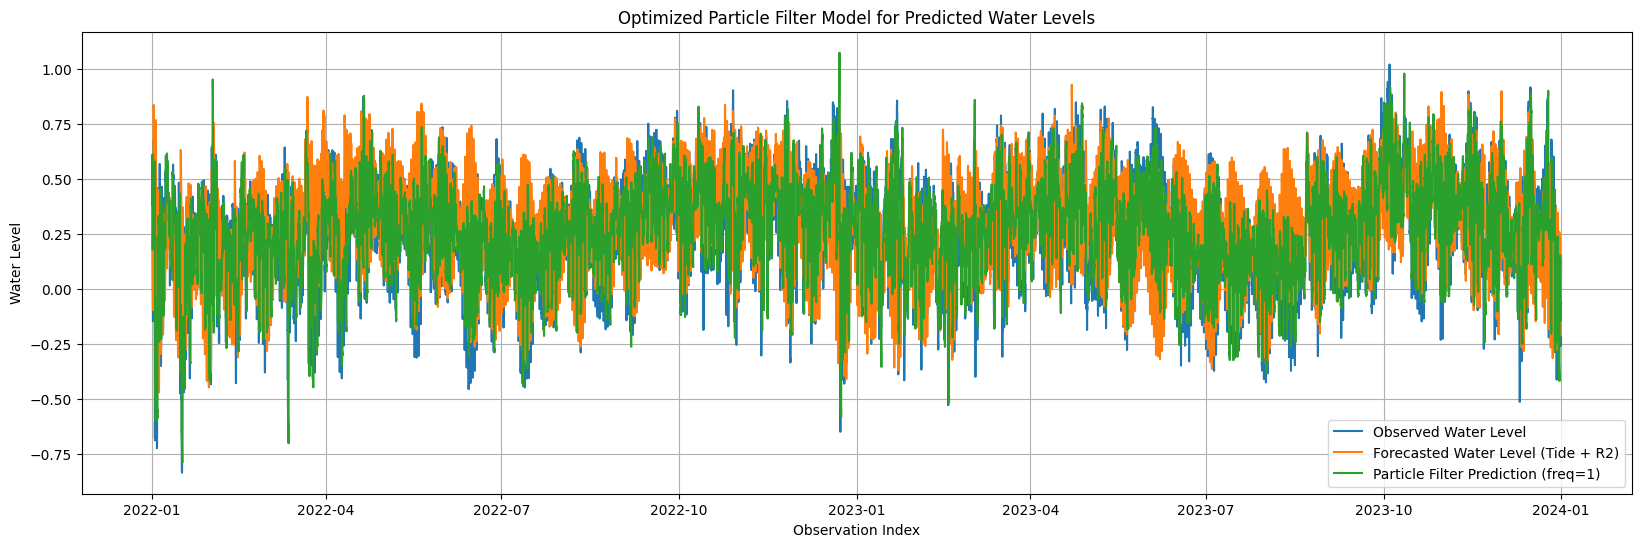

In [68]:
M = len(merged_df)
# M = 500

# Plot results
plt.figure(figsize=(20, 6))
plt.plot(merged_df['Datetime'][:M], merged_df['Observed Water Level Point A'][:M], label="Observed Water Level")
# plt.scatter(merged_df['Datetime'][:M], merged_df['Observed Water Level Point A'][:M], label="Observed Water Level", marker='o', facecolors='none', edgecolors='b')
# plt.plot(merged_df['Datetime'][:M], merged_df['Predicted Water Level Point A'][:M], label="Predicted Water Level (Tide-only)" )
plt.plot(merged_df['Datetime'][:M], merged_df['predicted_WL_plus_wave'][:M], label="Forecasted Water Level (Tide + R2)")
plt.plot(merged_df['Datetime'][:M], predicted_check_3[:M], label="Particle Filter Prediction (freq=1)")
# plt.plot(merged_df['Datetime'][:M], predicted_check_2[:M], label="Particle Filter Prediction (freq=5)")
# plt.plot(merged_df['Datetime'][:M], predicted_check_3[:M], label="Particle Filter Prediction (freq=10)")
plt.xlabel("Observation Index")
plt.ylabel("Water Level")
plt.title("Optimized Particle Filter Model for Predicted Water Levels")
plt.grid()
plt.legend()
plt.show()

In [83]:
# Extract data for convenience
x_obs = merged_df['Observed Water Level Point A']
y_pred1 = merged_df['Predicted Water Level Point A']
y_pred2 = merged_df['predicted_WL_plus_wave']
y_pred3 = predicted_check
y_pred4 = predicted_check_2
y_pred5 = predicted_check_3
y_pred6 = predicted_check_4
y_pred7 = predicted_check_5
y_pred8 = predicted_check_6

# Compute R² values
r2_pred1 = r2_score(x_obs, y_pred1)
r2_pred2 = r2_score(x_obs, y_pred2)
r2_pred3 = r2_score(x_obs, y_pred3)
r2_pred4 = r2_score(x_obs, y_pred4)
r2_pred5 = r2_score(x_obs, y_pred5)
r2_pred6 = r2_score(x_obs, y_pred6)
r2_pred7 = r2_score(x_obs, y_pred7)
r2_pred8 = r2_score(x_obs, y_pred8)

print(r2_pred1)
print(r2_pred2)
print(r2_pred3)
print(r2_pred4)
print(r2_pred5)
print(r2_pred6)
print(r2_pred7)
print(r2_pred8)

0.038084917384102024
0.6784181272521221
0.9604312793201744
0.5950884833900315
0.05169430205043868
0.7574541660023448
0.35884395234175537
-0.17976821233112017


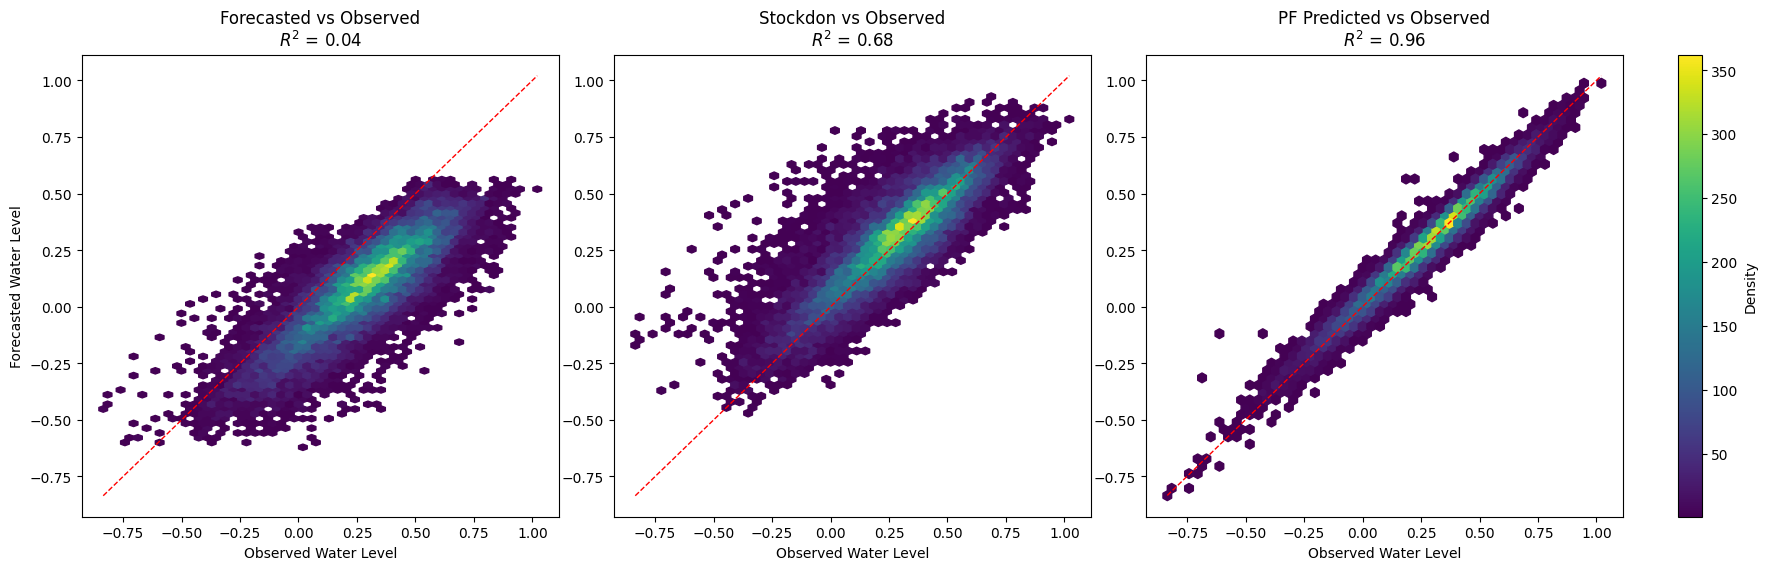

In [89]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Create a GridSpec layout
fig = plt.figure(figsize=(18, 6))
gs = GridSpec(1, 4, width_ratios=[1, 1, 1, 0.05], wspace=0.15)  # Adjust wspace for all subplots
gs.update(left=0.05, right=0.95)  # Adjust margins to prevent squeezing

# Create subplots
axs = [fig.add_subplot(gs[0, i]) for i in range(3)]

# Plot 1: Predicted Water Level vs Observed Water Level
hb1 = axs[0].hexbin(x_obs, y_pred1, gridsize=50, cmap='viridis', mincnt=1)
axs[0].plot([x_obs.min(), x_obs.max()], [x_obs.min(), x_obs.max()], color='red', linestyle='--', linewidth=1)
axs[0].set_title(f"Forecasted vs Observed\n$R^2$ = {r2_pred1:.2f}")
axs[0].set_xlabel("Observed Water Level")
axs[0].set_ylabel("Forecasted Water Level")

# Plot 2: PF Predictions vs Stockdon
hb2 = axs[1].hexbin(x_obs, y_pred2, gridsize=50, cmap='viridis', mincnt=1)
axs[1].plot([x_obs.min(), x_obs.max()], [x_obs.min(), x_obs.max()], color='red', linestyle='--', linewidth=1)
axs[1].set_title(f"Stockdon vs Observed\n$R^2$ = {r2_pred2:.2f}")
axs[1].set_xlabel("Observed Water Level")

# Plot 3: PF Predictions vs Observed Water Level
hb3 = axs[2].hexbin(x_obs, y_pred3, gridsize=50, cmap='viridis', mincnt=1)
axs[2].plot([x_obs.min(), x_obs.max()], [x_obs.min(), x_obs.max()], color='red', linestyle='--', linewidth=1)
axs[2].set_title(f"PF Predicted vs Observed\n$R^2$ = {r2_pred3:.2f}")
axs[2].set_xlabel("Observed Water Level")

# Add a colorbar to the right of the subplots
cbar_ax = fig.add_subplot(gs[0, 3])
fig.colorbar(hb3, cax=cbar_ax, label='Density')

# Adjust layout
# plt.tight_layout()
plt.show()


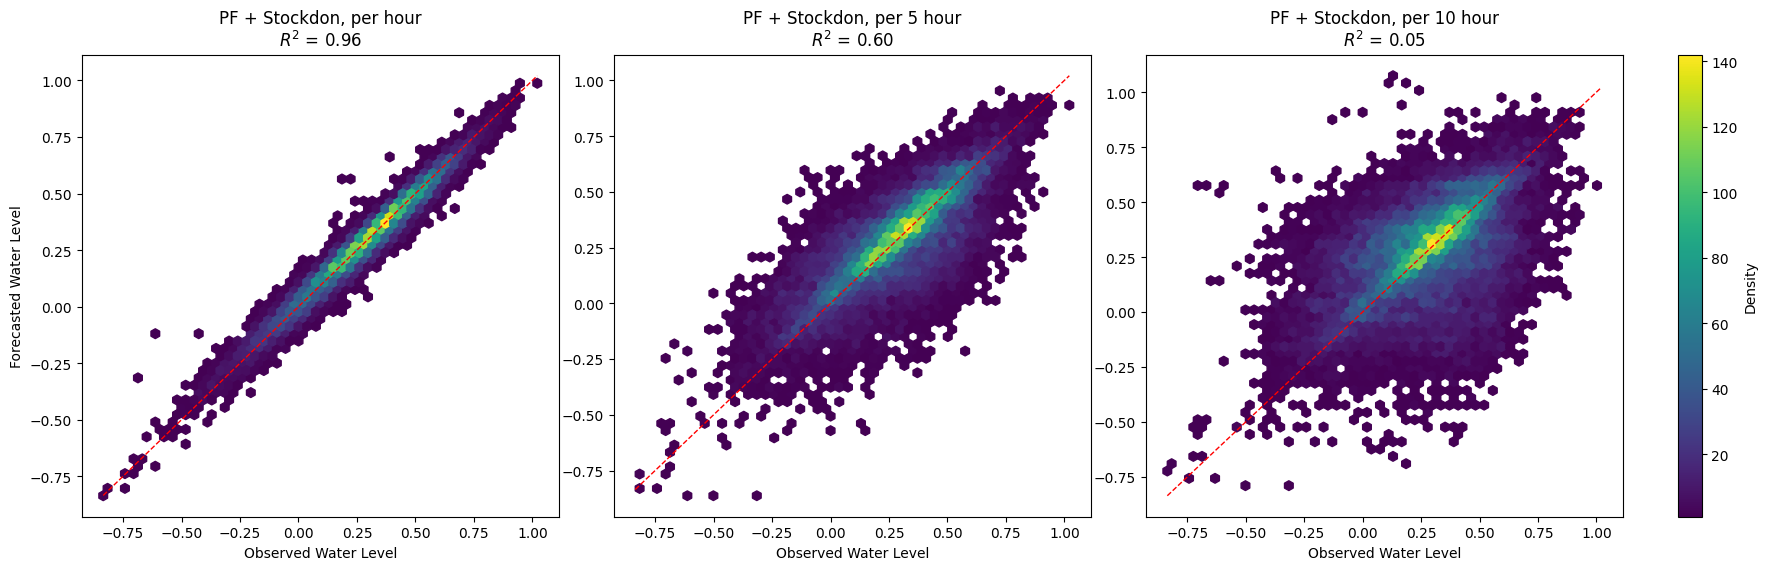

In [92]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Create a GridSpec layout
fig = plt.figure(figsize=(18, 6))
gs = GridSpec(1, 4, width_ratios=[1, 1, 1, 0.05], wspace=0.15)  # Adjust wspace for subplots
gs.update(left=0.05, right=0.95)  # Adjust margins to prevent squeezing

# Create subplots
axs = [fig.add_subplot(gs[0, i]) for i in range(3)]

# Plot 1: Predicted Water Level vs Observed Water Level
hb1 = axs[0].hexbin(x_obs, y_pred3, gridsize=50, cmap='viridis', mincnt=1)
axs[0].plot([x_obs.min(), x_obs.max()], [x_obs.min(), x_obs.max()], color='red', linestyle='--', linewidth=1)
axs[0].set_title(f"PF + Stockdon, per hour\n$R^2$ = {r2_pred3:.2f}")
axs[0].set_xlabel("Observed Water Level")
axs[0].set_ylabel("Forecasted Water Level")

# Plot 2: PF Predictions vs Stockdon
hb2 = axs[1].hexbin(x_obs, y_pred4, gridsize=50, cmap='viridis', mincnt=1)
axs[1].plot([x_obs.min(), x_obs.max()], [x_obs.min(), x_obs.max()], color='red', linestyle='--', linewidth=1)
axs[1].set_title(f"PF + Stockdon, per 5 hour\n$R^2$ = {r2_pred4:.2f}")
axs[1].set_xlabel("Observed Water Level")

# Plot 3: PF Predictions vs Observed Water Level
hb3 = axs[2].hexbin(x_obs, y_pred5, gridsize=50, cmap='viridis', mincnt=1)
axs[2].plot([x_obs.min(), x_obs.max()], [x_obs.min(), x_obs.max()], color='red', linestyle='--', linewidth=1)
axs[2].set_title(f"PF + Stockdon, per 10 hour\n$R^2$ = {r2_pred5:.2f}")
axs[2].set_xlabel("Observed Water Level")

# Add a colorbar to the right of the subplots
cbar_ax = fig.add_subplot(gs[0, 3])
fig.colorbar(hb3, cax=cbar_ax, label='Density')

# Adjust layout
# plt.tight_layout()
plt.show()


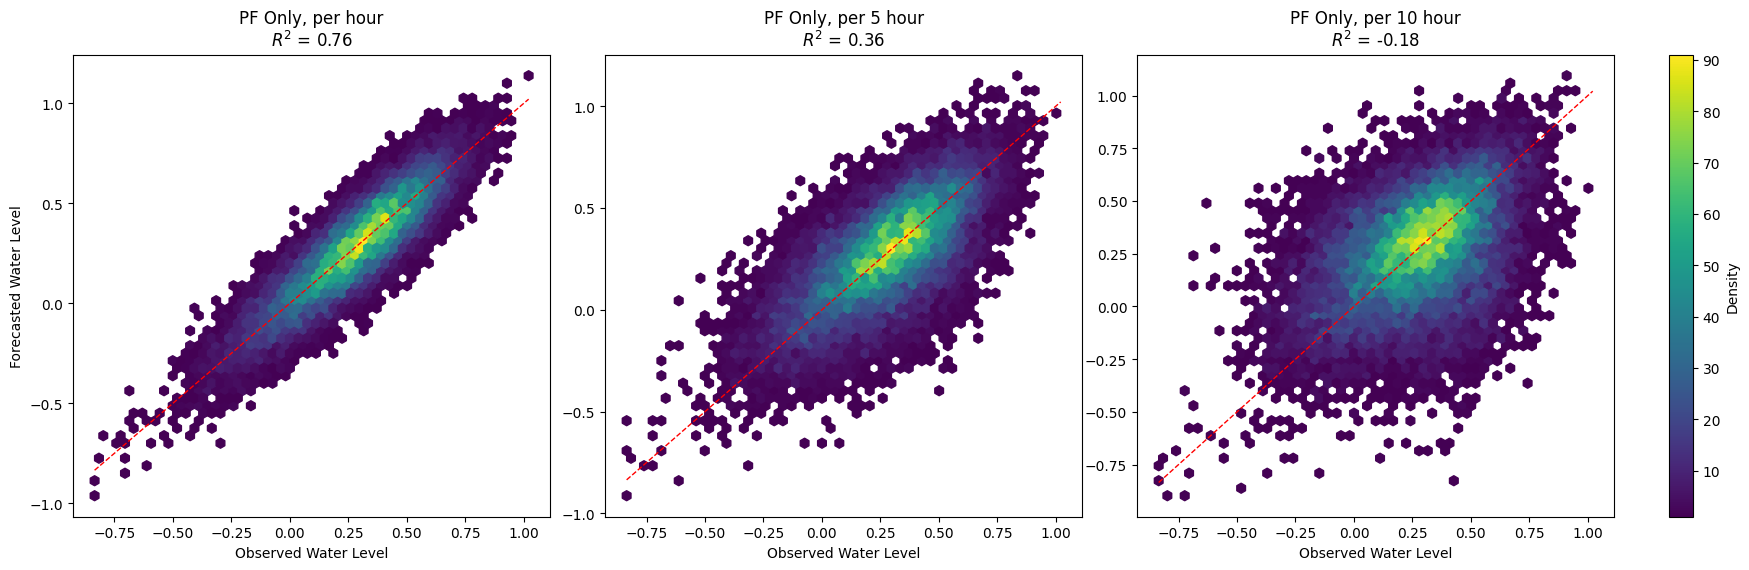

In [95]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Create a GridSpec layout
fig = plt.figure(figsize=(18, 6))
gs = GridSpec(1, 4, width_ratios=[1, 1, 1, 0.05], wspace=0.15)  # Adjust wspace for subplots
gs.update(left=0.05, right=0.95)  # Adjust margins to prevent squeezing

# Create subplots
axs = [fig.add_subplot(gs[0, i]) for i in range(3)]

# Plot 1: Predicted Water Level vs Observed Water Level
hb1 = axs[0].hexbin(x_obs, y_pred6, gridsize=50, cmap='viridis', mincnt=1)
axs[0].plot([x_obs.min(), x_obs.max()], [x_obs.min(), x_obs.max()], color='red', linestyle='--', linewidth=1)
axs[0].set_title(f"PF Only, per hour\n$R^2$ = {r2_pred6:.2f}")
axs[0].set_xlabel("Observed Water Level")
axs[0].set_ylabel("Forecasted Water Level")

# Plot 2: PF Predictions vs Stockdon
hb2 = axs[1].hexbin(x_obs, y_pred7, gridsize=50, cmap='viridis', mincnt=1)
axs[1].plot([x_obs.min(), x_obs.max()], [x_obs.min(), x_obs.max()], color='red', linestyle='--', linewidth=1)
axs[1].set_title(f"PF Only, per 5 hour\n$R^2$ = {r2_pred7:.2f}")
axs[1].set_xlabel("Observed Water Level")

# Plot 3: PF Predictions vs Observed Water Level
hb3 = axs[2].hexbin(x_obs, y_pred8, gridsize=50, cmap='viridis', mincnt=1)
axs[2].plot([x_obs.min(), x_obs.max()], [x_obs.min(), x_obs.max()], color='red', linestyle='--', linewidth=1)
axs[2].set_title(f"PF Only, per 10 hour\n$R^2$ = {r2_pred8:.2f}")
axs[2].set_xlabel("Observed Water Level")

# Add a colorbar to the right of the subplots
cbar_ax = fig.add_subplot(gs[0, 3])
fig.colorbar(hb3, cax=cbar_ax, label='Density')

# Adjust layout
# plt.tight_layout()
plt.show()


### UNUSED

In [71]:
# # Export pf_predictions to CSV
# output_df = pd.DataFrame({
#     "Datetime": merged_df["Datetime"],
#     "PF_Predictions": predicted
# })
# output_df.to_csv("pf_predictions_160125.csv", index=False)

In [72]:
# Optimization

def objective(trial):
    params = {
        "forecast_error_x1": trial.suggest_float("forecast_error_x1", 0, 0.25, step=0.01),
        "forecast_error_R2": trial.suggest_float("forecast_error_R2", 0, 0.25, step=0.01),
        "observation_error": trial.suggest_float("observation_error", 0, 0.5, step=0.01),
    }

    observation_error = np.array([params["observation_error"]])

    forecast_error = np.array([
        params["forecast_error_x1"],
        params["forecast_error_R2"],
        0
    ])
    # Ensemble parameters
    N = 100  # Number of particles

    prior_mean_x1 = merged_df['Predicted Water Level Point A'].iloc[0]
    prior_mean_R2 = merged_df['R2'].iloc[0]
    prior_mean_obs = merged_df['Observed Water Level Point A'].iloc[0]
    prior_mean_array = np.array([prior_mean_x1, prior_mean_R2, prior_mean_obs])

    prior_cov_array = np.array([
        [0,     0,      0],
        [0,     0,      0],
        [0,     0,      0],
    ])

    # Draw Samples
    X_samples = scipy.stats.multivariate_normal.rvs(mean=prior_mean_array, cov=prior_cov_array, size=N)
    X_samples = X_samples.T

    # Generate the initial sample weights
    w       = np.ones(N)/N

    X = X_samples

    assimilation_frequency = 1  # Example: assimilation happens at every time step (adjust as needed)

    # Define the total number of time steps (T)
    T = len(merged_df)
    # T = 200

    X_a = {}
    X_f = {}
    X_f[0] = copy.copy(X)

    predicted = []

    for t in range(T):

        # Perform assimilation step if needed
        if (t + 1) % assimilation_frequency == 0:
            observed_wl = merged_df.iloc[t]['Observed Water Level Point A']
            X, w = assimilation(X, w, observed_wl, observation_error)
            X_a[t] = copy.copy(X)
                    
        # Perform forecast step
        if t < T - 1:
            stokdon_R2 = merged_df.iloc[t]['R2']
            X = forecast(X, stokdon_R2, forecast_error)
            X_f[t+1] = copy.copy(X)
        
        predicted.append(np.mean(X[2,:]))
    
    residual = predicted - merged_df['Observed Water Level Point A'][:T]
    RMSE = np.sqrt(np.mean(residual ** 2))

    return RMSE

In [73]:
# import optuna

# # Initialize Optuna study
# study = optuna.create_study(direction="minimize")
# study.optimize(objective, n_trials=50)

# # Get the best parameters
# optimal_params = study.best_params
# print("Optimal Parameters Found:", optimal_params)